# Import libraries

In [1]:
import random
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras_tuner import BayesianOptimization
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from tensorflow import keras

np.set_printoptions(precision=3, suppress=True)

DOF = 2
SEED = 1

%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/

df_path = f'datasets/r{DOF}s{SEED}.csv'
try:
    df = pd.read_csv(df_path, sep=';', header=0)
except FileNotFoundError:
    raise FileNotFoundError(f"Dataset not found at path:{df_path}")

if DOF == 2:
    X = df[['j0', 'j1']].values
    Y = df[['ft_x', 'ft_y']].values
    out_dim = 2
elif DOF == 3:
    X = df[['j0', 'j1', 'j2']].values
    Y = df[['ft_x', 'ft_y']].values
    out_dim = 2
elif DOF == 5:
    X = df[['j0', 'j1', 'j2', 'j3', 'j4']].values
    Y = df[['ft_x', 'ft_y', 'ft_z']].values
    out_dim = 3
else:
    raise ValueError(f'Unsupported DOF value: {DOF}. No robot data available')

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=SEED)

# TensorBoard logging
log_dir = "logs/" + datetime.now().strftime(f"r{DOF}s{SEED}")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

2024-12-08 23:27:34.595732: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-08 23:27:34.605039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733696854.616199  193135 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733696854.620100  193135 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 23:27:34.634936: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

FNN

Reloading Tuner from my_tuner_dir/r2s1/tuner0.json
The optimal number of layers is 3
The best learning rate is 0.01
The dropout rate is 0.0
The selected optimizer is adam
Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6390 - loss: 0.0336 - val_accuracy: 0.7600 - val_loss: 0.0040 - learning_rate: 0.0100
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8552 - loss: 0.0029 - val_accuracy: 0.8900 - val_loss: 0.0013 - learning_rate: 0.0100
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9131 - loss: 0.0011 - val_accuracy: 0.9100 - val_loss: 4.1254e-04 - learning_rate: 0.0100
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9371 - loss: 3.6015e-04 - val_accuracy: 0.9500 - val_loss: 2.3915e-04 - learning_rate: 0.0100
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9825 - loss: 1.9883e-04 - val_accuracy: 0.9400 - val_loss: 1.2646e-04 - learning_rate: 0.0100
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

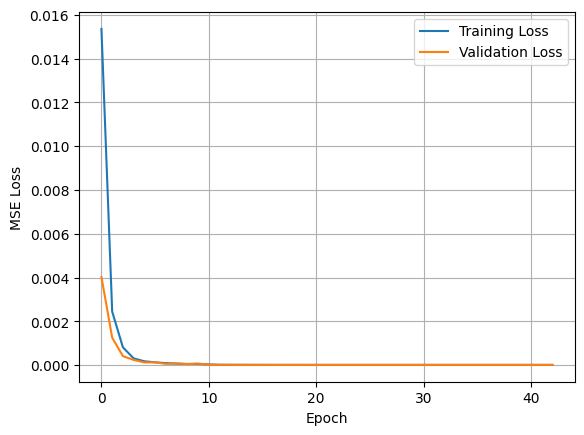

In [3]:
def build_model(hp):
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(X_train))
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(X.shape[1],)))
    model.add(normalizer)
    
    # Tune the number of layers and units per layer
    for i in range(hp.Int("num_layers", 1, 3)):  # 1 to 3 layers
        model.add(tf.keras.layers.Dense(
            units=hp.Int(f"layer_{i}", min_value=16, max_value=128, step=16),
            activation='relu'))
        # Add dropout with tuning dropout rate
        model.add(tf.keras.layers.Dropout(rate=hp.Float("dropout_rate", min_value=0, max_value=0.5, step=0.1)))
    
    model.add(tf.keras.layers.Dense(Y.shape[1]))  # Output layer
    
    # Tune the optimizer and learning rate for the optimizer
    optimizer = hp.Choice("optimizer", ["adam", "sgd"])

    if optimizer == "adam":
        selected_optimizer = keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4]))
    elif optimizer == "sgd":
        selected_optimizer = keras.optimizers.SGD(
            learning_rate=hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4]),
            momentum=hp.Choice("momentum", [0.0, 0.5, 0.9]))
    else:
        pass

    # Compile the model with the selected optimizer
    model.compile(
        optimizer=selected_optimizer,
        loss='mse',
        metrics=['accuracy'])
    
    return model

# Add callbacks for early stopping and learning rate scheduling
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=1)

# Initialize the tuner
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=50,
    directory='my_tuner_dir',
    project_name=f'r{DOF}s{SEED}')

# Run the hyperparameter search with batch size tuning8
tuner.search(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    batch_size=32,  # Tuning batch size
    epochs=200,
    callbacks=[tensorboard_callback, early_stopping, lr_scheduler],
    verbose=1)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"The optimal number of layers is {best_hps.get('num_layers')}")
print(f"The best learning rate is {best_hps.get('learning_rate')}")
print(f"The dropout rate is {best_hps.get('dropout_rate')}")
print(f"The selected optimizer is {best_hps.get('optimizer')}")

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the best model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler, tensorboard_callback],
    verbose=1)

# Save the trained model
model.save(f'FNN_r{DOF}s{SEED}.keras')

# Load a saved model
# model = tf.keras.models.load_model('fk/FNN_r5s2.keras')

# Plot the loss curve
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history)

In [20]:
# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the best model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler, tensorboard_callback],
    verbose=1)

Epoch 1/200


/home/fasc/MLHW1_robot_kinematics/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6435 - loss: 0.0383 - val_accuracy: 0.8700 - val_loss: 0.0038 - learning_rate: 0.0100
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8876 - loss: 0.0029 - val_accuracy: 0.9100 - val_loss: 0.0015 - learning_rate: 0.0100
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9206 - loss: 0.0014 - val_accuracy: 0.8450 - val_loss: 9.3430e-04 - learning_rate: 0.0100
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9100 - loss: 7.1485e-04 - val_accuracy: 0.9450 - val_loss: 6.2792e-04 - learning_rate: 0.0100
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9236 - loss: 5.1488e-04 - val_accuracy: 0.9050 - val_loss: 6.3679e-04 - learning_rate: 0.0100
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9332 - loss: 3.2548e-04 - val_accuracy: 0.9300 - val_loss: 2.8350e-04 - learning_rate: 0.0100
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9419 - loss:

SVR

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'estimator__C': 50.0, 'estimator__epsilon': 0.0001, 'estimator__kernel': 'rbf'}
SVR - Overall Mean Squared Error: 1.6970550570912095e-07
SVR - Overall R2 Score: 0.9999807798408007


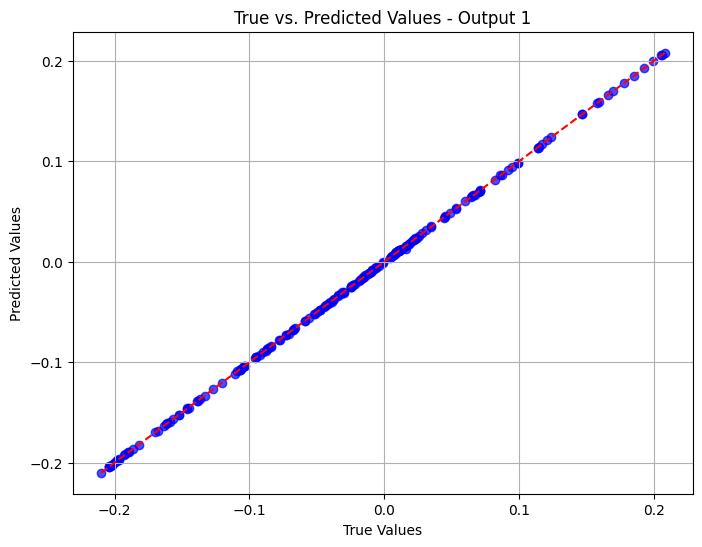

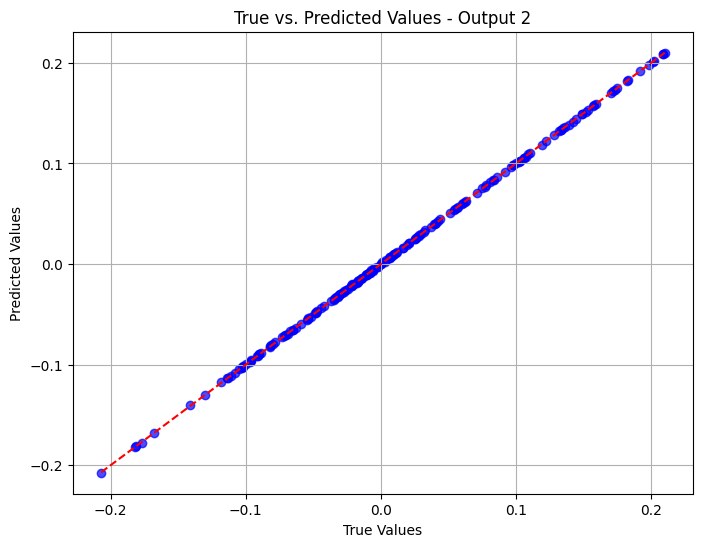

In [4]:
# Scale input data
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Define parameter grid for GridSearchCV
param_grid = {
    'estimator__C': [25.0, 50.0, 100.0],
    'estimator__epsilon': [1e-5, 1e-4, 1e-3],
    'estimator__kernel': ['rbf']
}

# Initialize the SVR model and wrap it with MultiOutputRegressor
svr_model = MultiOutputRegressor(SVR())

# Perform GridSearchCV for the multi-output SVR model
grid_search = GridSearchCV(svr_model, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, Y_train)  # Y_train is now multi-output (e.g., 2D)

# Best parameters
print(f"Best parameters: {grid_search.best_params_}")

# Make predictions using the best estimator
Y_pred_svr = grid_search.best_estimator_.predict(X_test_scaled)

# Evaluate performance for multi-output regression
mse_svr = mean_squared_error(Y_test, Y_pred_svr)
r2_svr = r2_score(Y_test, Y_pred_svr)

print(f"SVR - Overall Mean Squared Error: {mse_svr}")
print(f"SVR - Overall R2 Score: {r2_svr}")

# Visualization for each output dimension
for i in range(Y_test.shape[1]):  # Iterate over the number of output dimensions
    plt.figure(figsize=(8, 6))
    plt.scatter(Y_test[:, i], Y_pred_svr[:, i], alpha=0.7, color='blue')
    plt.plot([min(Y_test[:, i]), max(Y_test[:, i])], [min(Y_test[:, i]), max(Y_test[:, i])], color='red', linestyle='--')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"True vs. Predicted Values - Output {i+1}")
    plt.grid()
    plt.show()


SVR - Overall Mean Squared Error: 7.547144135366496e-05
SVR - Overall R2 Score: 0.9912439128461028


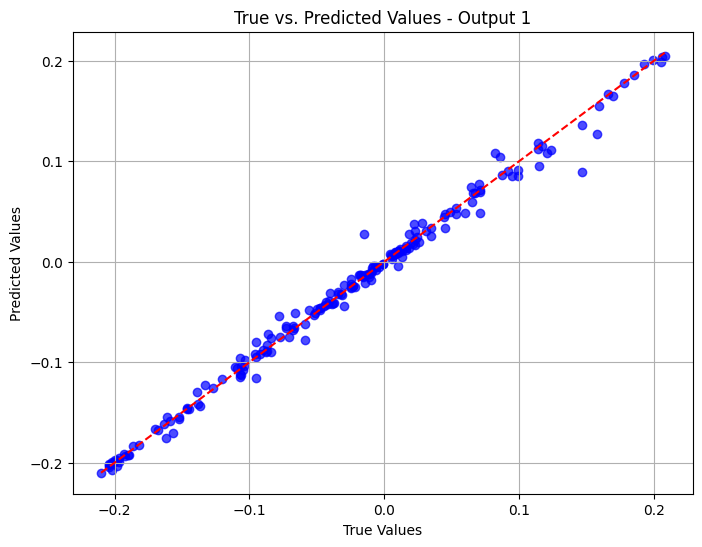

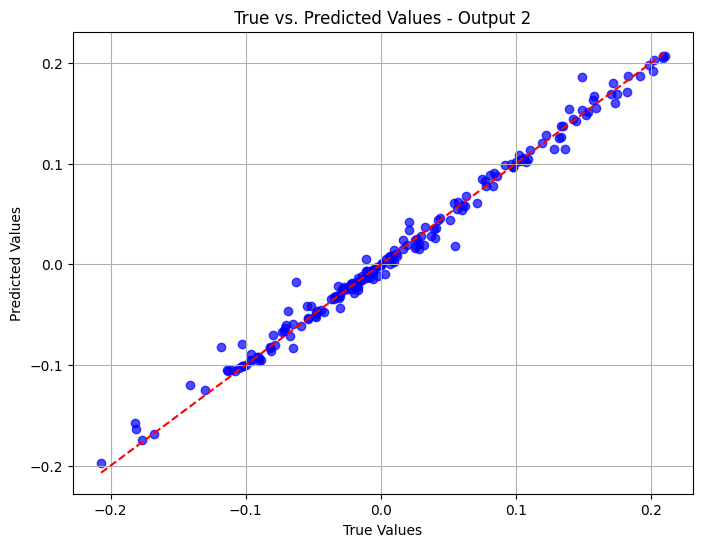

In [21]:
# Make predictions using the best estimator
Y_pred_svr = grid_search.best_estimator_.predict(X_test_scaled)

# Evaluate performance for multi-output regression
mse_svr = mean_squared_error(Y_test, Y_pred_svr)
r2_svr = r2_score(Y_test, Y_pred_svr)

print(f"SVR - Overall Mean Squared Error: {mse_svr}")
print(f"SVR - Overall R2 Score: {r2_svr}")

# Visualization for each output dimension
for i in range(Y_test.shape[1]):  # Iterate over the number of output dimensions
    plt.figure(figsize=(8, 6))
    plt.scatter(Y_test[:, i], Y_pred_svr[:, i], alpha=0.7, color='blue')
    plt.plot([min(Y_test[:, i]), max(Y_test[:, i])], [min(Y_test[:, i]), max(Y_test[:, i])], color='red', linestyle='--')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"True vs. Predicted Values - Output {i+1}")
    plt.grid()
    plt.show()

KNR

In [6]:
# Define the model
knn = KNeighborsRegressor()

# Define the hyperparameter grid
param_grid = {
    'n_neighbors': [2, 3, 5],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Grid search
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, Y_train)

# Best parameters
print(grid_search.best_params_)

# Get the best estimator from grid search
best_knn = grid_search.best_estimator_

# Predict on the test set
y_pred = best_knn.predict(X_test_scaled)

# Evaluate performance
mse = mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

print(f"Test Set Performance:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R2 Score: {r2}")


Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Test Set Performance:
Mean Squared Error (MSE): 7.547144135366496e-05
R2 Score: 0.9912439128461028


Compare Jacobians (Only for 2 Degrees of Freedom)

In [18]:
# Forward kinematics function (as given)
def FK(model, theta):
    t = tf.reshape(theta, shape=(1, 2))  # Reshape input to batch size 1
    out = model(t)  # Model output (position)
    out = tf.reshape(out, shape=(2,))  # Reshape to 1D vector (x, y)
    return out

# FK Jacobian function (as given)
@tf.function
def FK_Jacobian(model, x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y = FK(model, x)  # Compute forward kinematics
    return tape.jacobian(y, x)  # Return Jacobian matrix

def analytical_jacobian(joint_angles, link_lengths=[0.1, 0.1]):
    j0, j1 = joint_angles
    l1, l2 = link_lengths
    
    dx_dj0 = -l1 * np.sin(j0) - l2 * np.sin(j0 + j1)
    dx_dj1 = -l2 * np.sin(j0 + j1)
    dy_dj0 = l1 * np.cos(j0) + l2 * np.cos(j0 + j1)
    dy_dj1 = l2 * np.cos(j0 + j1)
    
    J = np.array([[dx_dj0, dx_dj1],
              [dy_dj0, dy_dj1]])
    
    return J

sample = random.choice(X_test).reshape(1, -1)

# Compute model and analytical Jacobians
model_jacobian = FK_Jacobian(model, tf.convert_to_tensor(sample, dtype=tf.float32)).numpy()
analytical_jacobian_result = analytical_jacobian(sample[0])

# Print results
print(f"Sampled Joints: {sample}")
print(f"Model Jacobian: \n{model_jacobian}\n")
print(f"Analytical Jacobian: \n{analytical_jacobian_result}\n")


jacobian_error = np.abs(model_jacobian - analytical_jacobian_result)
print(f"Jacobian Error: \n{jacobian_error[0][0]} \n{jacobian_error[1][1]}")

Sampled Joints: [[2.222 2.606]]
Model Jacobian: 
[[[ 0.045  0.118]]

 [[-0.039  0.018]]]

Analytical Jacobian: 
[[ 0.02   0.099]
 [-0.049  0.012]]

Jacobian Error: 
[0.025 0.019] 
[0.01  0.007]


Inverse Kinematics using Newton-Raphson (Only for 2 Degrees of Freedom)

In [19]:
# Inverse Kinematics using Newton-Raphson Method
def newton_raphson_inverse_kinematics(target, initial_state, tol=1e-6, max_iter=100):
    theta = np.array(initial_state, dtype=np.float32)  # Initialize joint angles
    target = target.reshape(-1)  # Ensure target is 1D

    for i in range(max_iter):
        # Compute current end-effector position
        pos = FK(model, tf.convert_to_tensor(theta, dtype=tf.float32)).numpy()
        # Compute the error between the target and the current position
        error = target - pos
        
        if np.linalg.norm(error) < tol:
            print(f"Converged in {i} iterations.")
            return theta
        
        # Compute the Jacobian
        J = FK_Jacobian(model, tf.convert_to_tensor(theta, dtype=tf.float32)).numpy()
        
        # Update the angles using the pseudo-inverse
        delta_theta = np.dot(np.linalg.pinv(J), error)
        theta += delta_theta  # Update joint angles
    
    raise RuntimeError("Newton-Raphson did not converge within the maximum number of iterations")

# Test the IK solver
target = random.choice(Y_test)  # Random target position
print(f"Target position: {target}")

initial_joints = [0.0, 0.0]  # Initial guess for joint angles

try:
    joint_angles = newton_raphson_inverse_kinematics(target, initial_joints)
    print(f"Joint angles (radians): {joint_angles}")
    end_effector_pos = FK(model, tf.convert_to_tensor(joint_angles, dtype=tf.float32)).numpy()
    print(f"End-effector position from model: {end_effector_pos}")
except RuntimeError as e:
    print(e)


Target position: [ 0.018 -0.022]
Converged in 6 iterations.
Joint angles (radians): [2.821 3.4  ]
End-effector position from model: [ 0.018 -0.022]
